In [5]:
# libraries to import
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1)

# Stochastic Linear Bandits

# Strategy 1: UCB Algorithm

The difference here is that instead of having confidence intervals, we have confidence ellipsoids.

The goal of the algorithm is to optimize the selection of actions (arms) in order to maximize the cumulative reward received over a series of rounds.

The key idea behind the algorithm is to model the relationship between the observed rewards and the features of each arm using linear regression, and then use the estimated regression coefficients to make informed decisions about which arm to select in each round.

### Steps of the algorithm



In [19]:
# --------- Start of the algorithm LinUCB -----------
def linUCB_algorithm(n_arms, n_features, item_features, true_theta, n_rounds, noise, lambda_param, beta_param, delta_param):
    
    # Initialize feature matrix.
    # V_t[i, j] represents the sum of the product of the ith and jth feature components across all observed data points.
    # V_t[i, i] represents the sum of the squared ith feature components.
    # Initializing V_0 to lambda * Identity matrix makes it invertible.
    V_t = lambda_param * np.eye(n_features)

    # Initialize label vector.
    # Represents the sum of the product of the observed rewards with each feature component across all observed data points.
    sum_A_s_X_s = np.zeros(n_features)
    
    # Initialize theta_hat matrix, where each column represents the estimate of the true_theta vector at each round.
    theta_hat = np.zeros((n_features, n_rounds + 1))
    theta_hat[:, 0] = np.random.uniform(low=0, high=1, size=(n_features, 1)).reshape((n_features,))


    # Initialize arrays to store actions, rewards and regrets.
    actions = np.zeros(n_rounds + 1, dtype=int)
    rewards = np.zeros(n_rounds + 1)
    regrets = np.zeros(n_rounds + 1)
    
    print("theta at time step 0 : ")
    print(theta_hat[:, 0])

    for t in range(1, n_rounds + 1):
        
        # Compute beta parameter for this round using the given formula.
        beta_param_t = 1.0 #* np.log(t * 2) # 2 * np.log(t * n_arms * lambda_param / delta_param)
        # print("beta param : " + str(beta_param_t))
        
        # Choose the best action based on the last theta_hat.
        max_value = -np.Inf
        max_index = -1
        print(V_t)
        print(np.linalg.inv(V_t))
        for i in range(n_arms):
            # Compute the UCB for each arm using the given formula.
            estimated_value = theta_hat[:, t-1].T @ item_features[:, i]
            penalty_value = np.sqrt(beta_param_t) * np.sqrt(item_features[:, i].T @ (np.linalg.inv(V_t) @ item_features[:, i]))
            value = estimated_value + penalty_value
            # print("Values for arm " + str(i) + " : ", estimated_value, penalty_value, value)
            if value >= max_value:
                max_value = value
                max_index = i
        # Update the best action to take for this round.
        actions[t] = max_index
        
        # print("best action to take : ", actions[t])
        
        # Observe the reward of the chosen action and add noise.
        expected_reward = true_theta.T @ item_features[:, actions[t]]
        rewards[t] = expected_reward + np.random.normal(scale=noise) # this might be the reason why we get negative regret
        
        # print("current reward of chosen action : " + str(rewards[t]))
        
        # Compute the regret for this round.
        optimal_reward = np.max(item_features.T @ true_theta) # todo put this outside the for loop
        # print("optimal reward possible : " + str(optimal_reward) + " with arm " + str(np.argmax(item_features.T @ true_theta)))
        regret = optimal_reward - expected_reward
        # print("regret : " + str(regret))
        regrets[t] = regrets[t - 1] + regret
        
        # Update the feature matrix V_t by adding the outer product of the chosen action's feature vector with itself.
        V_t += np.outer(item_features[:, actions[t]], item_features[:, actions[t]])
        # V_t += item_features[:, actions[t]] @ item_features[:, actions[t]].T 
        
        # Compute the inverse of the updated feature matrix V_t.
        V_t_inv = np.linalg.inv(V_t)
        print(V_t)
        print(V_t_inv)
        # Update the label vector sum_A_s_X_s by adding the outer product of the chosen action's feature vector with the observed reward.
        sum_A_s_X_s += item_features[:, actions[t]] * rewards[t]
        
        # Compute the new estimate of the true_theta vector using the updated feature matrix and label vector.
        # This estimate represents the center of the ellipsoid in the feature space.
        # theta_hat_not_normalized = V_t_inv @ sum_A_s_X_s
        theta_hat[:, t] = V_t_inv @ sum_A_s_X_s # theta_hat_not_normalized / np.linalg.norm(theta_hat_not_normalized) # todo idk if we should normalize this np.linalg.norm()

        # theta_hat_not_normalized = V_t_inv @ sum_A_s_X_s
        # theta_hat[:, t] = theta_hat_not_normalized / np.linalg.norm(theta_hat_not_normalized)

        
        # print("theta at time step " + str(t) + " : ")
        # print(theta_hat[:, t])
        print(np.linalg.eigvalsh(V_t_inv))
        print(np.linalg.eigvalsh(V_t))
        print(" -------------\n ")
        
    return actions, rewards, regrets, theta_hat[:, n_rounds]


theta at time step 0 : 
[0.16612596 0.25917862 0.1825025  0.17807243 0.22776821]
[[0.5 0.  0.  0.  0. ]
 [0.  0.5 0.  0.  0. ]
 [0.  0.  0.5 0.  0. ]
 [0.  0.  0.  0.5 0. ]
 [0.  0.  0.  0.  0.5]]
[[2. 0. 0. 0. 0.]
 [0. 2. 0. 0. 0.]
 [0. 0. 2. 0. 0.]
 [0. 0. 0. 2. 0.]
 [0. 0. 0. 0. 2.]]
[[ 1.01707859 -0.52984414  0.18083234 -0.61503048 -0.66463409]
 [-0.52984414  1.04292484 -0.18529669  0.63021425  0.68104246]
 [ 0.18083234 -0.18529669  0.56324055 -0.215088   -0.23243534]
 [-0.61503048  0.63021425 -0.215088    1.23153772  0.7905379 ]
 [-0.66463409  0.68104246 -0.23243534  0.7905379   1.35429658]]
[[ 1.67774012  0.33021578 -0.11270048  0.38330662  0.41422118]
 [ 0.33021578  1.66163191  0.11548281 -0.39276963 -0.4244474 ]
 [-0.11270048  0.11548281  1.96058647  0.13404971  0.14486112]
 [ 0.38330662 -0.39276963  0.13404971  1.54408235 -0.49268845]
 [ 0.41422118 -0.4244474   0.14486112 -0.49268845  1.4675751 ]]
[0.31161596 2.         2.         2.         2.        ]
[0.5        0.5        

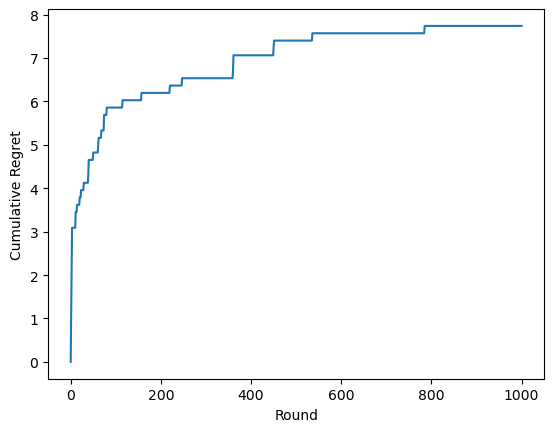

The true theta is equal to : [[-0.5000886 ]
 [-0.62377607]
 [-0.98328998]
 [ 0.3149123 ]
 [-0.25636593]]
The theta hat we find at the end is equal to : [-0.35833973 -0.47661386 -0.7569924   0.20296257 -0.17378312]


In [22]:
# Setting up parameters for the runs
n_arms = 20
n_features = 5
item_features = np.random.uniform(low=-1, high=1, size=(n_features, n_arms))
true_theta = np.random.uniform(low=-1, high=1, size=(n_features, 1))
# item_features = np.array([[1, 0], [0, 1]])
# true_theta = np.array([0.7, 0.3])
n_rounds = 1000
noise = 0.1 # 0.1 -> can lead to negative regret since the reward could be the optimal + some noise
beta_param = 2
lambda_param = 0.5
delta_param = 0.1

# Running the algorithm
actions, rewards, regrets, theta_hat = linUCB_algorithm(n_arms, n_features, item_features, true_theta, n_rounds, noise, lambda_param, beta_param, delta_param)

# Plotting the regret
plt.plot(regrets)
plt.xlabel('Round')
plt.ylabel('Cumulative Regret')
plt.show()

# Printing the true theta a
print("The true theta is equal to : " + str(true_theta))
print("The theta hat we find at the end is equal to : " + str(theta_hat / np.linalg.norm(theta_hat)))

In [8]:
print(true_theta)
print(item_features)

[0.7 0.3]
[[1 0]
 [0 1]]


In [9]:
# I will wrap everything in a class when I get a working algorithm

# class UCB_linear_bandit:
#     def __init__(self, true_theta, item_features, num_rounds, noise):
#         self.true_theta = true_theta
#         self.item_features = item_features
#         self.num_rounds = num_rounds
#         self.noise = noise
        
#         self.actions = np.zeros(num_rounds)
#         self.regrets = np.zeros(num_rounds)